# Convolutional Neural Networks

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD


# Cargar set de Imágenes

In [3]:
dirname = os.path.join(os.getcwd(),'riesgos/')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\futch\OneDrive\Documentos\semestre 9\ia\situaciones de riesgo\riesgos/\
c:\Users\futch\OneDrive\Documentos\semestre 9\ia\situaciones de riesgo\riesgos/\asaltos 1
c:\Users\futch\OneDrive\Documentos\semestre 9\ia\situaciones de riesgo\riesgos/\incendios 5404
c:\Users\futch\OneDrive\Documentos\semestre 9\ia\situaciones de riesgo\riesgos/\inundaciones 3502
c:\Users\futch\OneDrive\Documentos\semestre 9\ia\situaciones de riesgo\riesgos/\robo_habitacion 4986
c:\Users\futch\OneDrive\Documentos\semestre 9\ia\situaciones de riesgo\riesgos/\tornados 3988
Directorios leidos: 5
Imagenes en cada directorio [5405, 3502, 4986, 3988, 4977]
suma Total de imagenes en subdirs: 22858


# Creamos las etiquetas

In [4]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  22858


In [5]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 asaltos
1 incendios
2 inundaciones
3 robo_habitacion
4 tornados


In [6]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [7]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (18286, 21, 28, 3) (18286,)
Testing data shape :  (4572, 21, 28, 3) (4572,)


Text(0.5, 1.0, 'Ground Truth : 3')

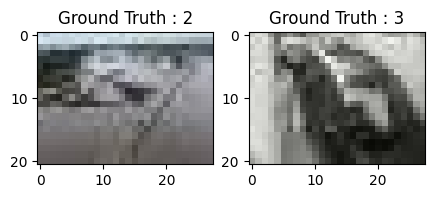

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

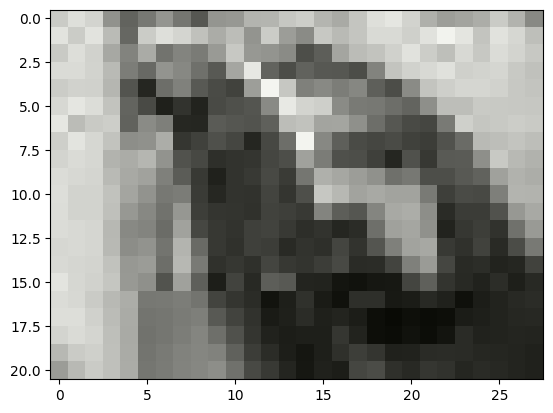

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [10]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [11]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [12]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(14628, 21, 28, 3) (3658, 21, 28, 3) (14628, 5) (3658, 5)


# Creamos el modelo de CNN

In [13]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [14]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

C:\Users\futch\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\futch\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 21, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 21, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4928)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       157,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,789 (620.27 KB)

 Trainable params: 158,789 (620.27 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

C:\Users\futch\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Entrenamos el modelo: Aprende a clasificar imágenes

In [17]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

sport_train = sport_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2256 - loss: 1.6468 - val_accuracy: 0.4535 - val_loss: 1.5138
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3056 - loss: 1.5343 - val_accuracy: 0.4836 - val_loss: 1.4360
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3333 - loss: 1.4944 - val_accuracy: 0.5079 - val_loss: 1.3584
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3826 - loss: 1.4293 - val_accuracy: 0.5768 - val_loss: 1.2805
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4291 - loss: 1.3662 - val_accuracy: 0.5943 - val_loss: 1.2072
Epoch 6/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4430 - loss: 1.3283 - val_accuracy: 0.6271 - val_loss: 1.1463
Epoch 7/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4684 - loss: 1.2865 - val_accuracy: 0.6400 - val_loss: 1.0929
Epoch 8/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5032 - loss: 1.2294 - val_accuracy: 0.

In [18]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("riesgos.h5")

# Evaluamos la red

In [19]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.6360


In [20]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6363605260848999
Test accuracy: 0.8530183434486389


In [21]:
sport_train.history

{'accuracy': [0.24856439232826233,
  0.31364506483078003,
  0.34926170110702515,
  0.39068907499313354,
  0.4306125342845917,
  0.4495488107204437,
  0.484823614358902,
  0.5029395818710327,
  0.5336341261863708,
  0.5505878925323486,
  0.568567156791687,
  0.5849740505218506,
  0.6089690923690796,
  0.6225731372833252,
  0.6372026205062866,
  0.6556603908538818,
  0.6661197543144226,
  0.6790401935577393,
  0.692165732383728,
  0.7065901160240173],
 'loss': [1.603929042816162,
  1.5218969583511353,
  1.4771394729614258,
  1.4193629026412964,
  1.357913613319397,
  1.3171032667160034,
  1.2662187814712524,
  1.2229968309402466,
  1.1765629053115845,
  1.1456905603408813,
  1.105345606803894,
  1.0697757005691528,
  1.0385353565216064,
  1.0070782899856567,
  0.981535792350769,
  0.945417046546936,
  0.9216580986976624,
  0.8909555673599243,
  0.873982310295105,
  0.8401058316230774],
 'val_accuracy': [0.4535265266895294,
  0.48359760642051697,
  0.5079278349876404,
  0.5768179297447205

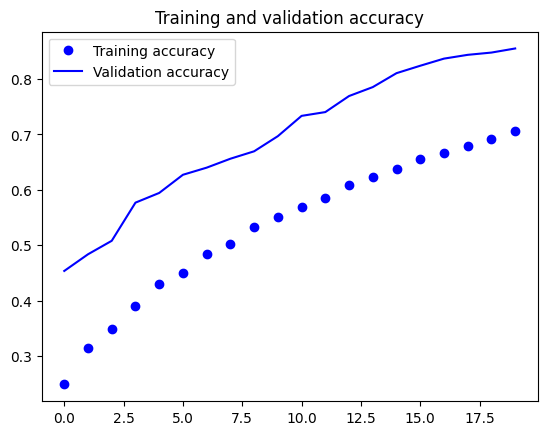

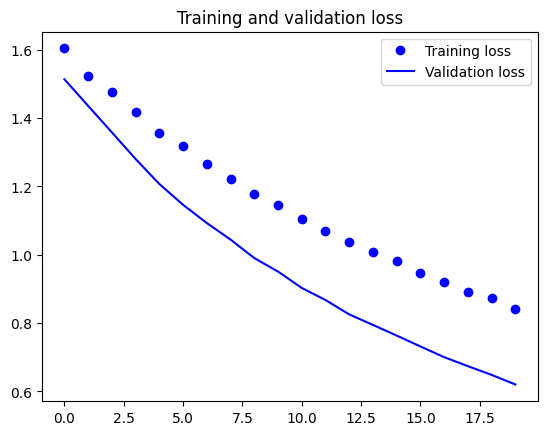

In [22]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
predicted_classes2 = sport_model.predict(test_X)

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [24]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [96]:
predicted_classes.shape, test_Y.shape

((4572,), (4572,))

# Aprendamos de los errores: Qué mejorar

Found 3900 correct labels


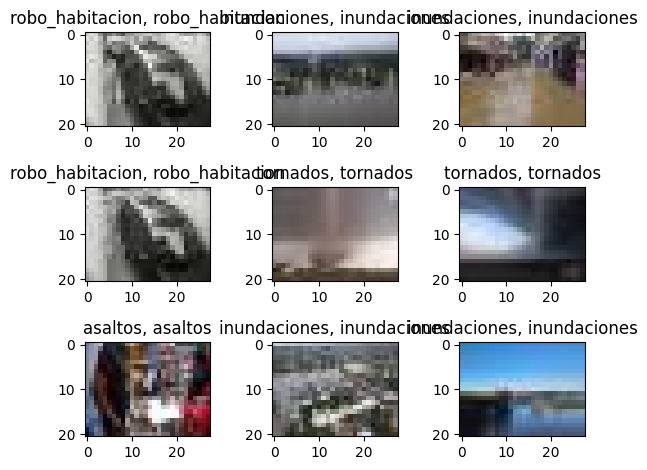

In [25]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 672 incorrect labels


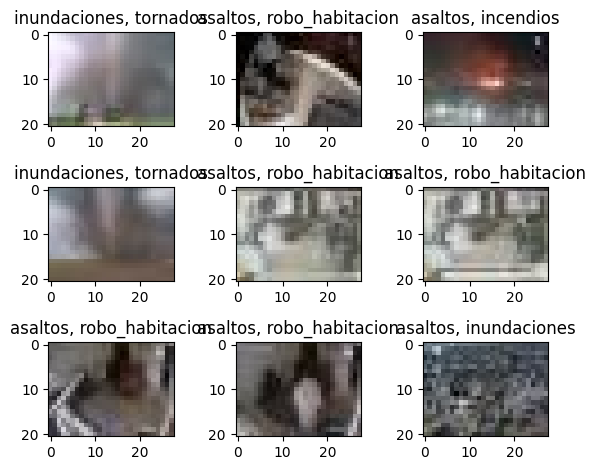

In [26]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [27]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.78      0.93      0.85      1093
     Class 1       0.96      0.83      0.89       689
     Class 2       0.78      0.93      0.85       993
     Class 3       0.93      0.72      0.81       810
     Class 4       0.93      0.80      0.86       987

    accuracy                           0.85      4572
   macro avg       0.88      0.85      0.85      4572
weighted avg       0.87      0.85      0.85      4572



In [47]:
from skimage.transform import resize
import cv2 as cv

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
# filenames = ['test/asalto1.jpg']
# filenames = ['test/casa1.jpg']
filenames = ['test/incendio2.jpg']
# filenames = ['test/inundacion1.jpg']
# filenames = ['test/tornado6.jpg']

resultado = " "
frame = cv.imread(filenames[0])

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])
    resultado = deportes[img_tagged.tolist().index(max(img_tagged))]
    
print(resultado)
    
cv.imshow("La situacion de riesgo es:    -"+resultado, frame)
cv.waitKey(0)
cv.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
test/incendio2.jpg incendios
incendios
